In [4]:
import pandas as pd
import time
from meta_algo import MetaAlgorithm
from sklearn.metrics import accuracy_score
import cvxopt
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [5]:
# show_proportions is only a helper function for plotting
def show_proportions(X, sensitive_features, y_pred, y=None, description="Demographic Parity", plot_row_index=1):
    print("\n" + description)
    plt.figure(plot_row_index)
    plt.title(description)
    plt.ylabel("P[recidivism predicted | conditions]")
    
    indices = {}
    positive_indices = {}
    negative_indices = {}
    recidivism_count = {}
    recidivism_pct = {}
    groups = np.unique(sensitive_features.values)
    n_groups = len(groups)
    max_group_length = max([len(group) for group in groups])
    color = cm.rainbow(np.linspace(0,1,n_groups))
    x_tick_labels_basic = []
    x_tick_labels_by_label = []
    for index, group in enumerate(groups):
        indices[group] = sensitive_features.index[sensitive_features == group]
        recidivism_count[group] = sum(y_pred[indices[group]])
        recidivism_pct[group] = recidivism_count[group]/len(indices[group])
        print("P[recidivism predicted | {}]                {}= {}".format(group, " "*(max_group_length-len(group)), recidivism_pct[group]))
    
        plt.bar(index + 1, recidivism_pct[group], color=color[index])
        x_tick_labels_basic.append(group)
    
        if y is not None:
            positive_indices[group] = sensitive_features.index[(sensitive_features == group) & (y == 1)]
            negative_indices[group] = sensitive_features.index[(sensitive_features == group) & (y == 0)]
            prob_1 = sum(y_pred[positive_indices[group]])/len(positive_indices[group])
            prob_0 = sum(y_pred[negative_indices[group]])/len(negative_indices[group])
            print("P[recidivism predicted | {}, recidivism]    {}= {}".format(group, " "*(max_group_length-len(group)) , prob_1))
            print("P[recidivism predicted | {}, no recidivism] {}= {}".format(group, " "*(max_group_length-len(group)), prob_0))

            plt.bar(n_groups + 1 + 2 * index, prob_1, color=color[index])
            plt.bar(n_groups + 2 + 2 * index, prob_0, color=color[index])
            x_tick_labels_by_label.extend(["{} recidivism".format(group), "{} no recidivism".format(group)])
    
    x_tick_labels = x_tick_labels_basic + x_tick_labels_by_label
    plt.xticks(range(1, len(x_tick_labels)+1), x_tick_labels, rotation=45, horizontalalignment="right")

dataset_used = 'compas'

if(dataset_used == 'compas'):
    compas_train = pd.read_csv('./../../data/compas_train.csv')
    compas_val = pd.read_csv('./../../data/compas_val.csv')
    compas_test = pd.read_csv('./../../data/compas_test.csv')

    y_train = compas_train.pop('two_year_recid') 
    y_test = compas_test.pop('two_year_recid')
    sensitive_features_train = compas_train['race']
    sensitive_features_test = compas_test['race']
    X_train = compas_train
    X_test = compas_test
    
    sensitive_features_train = sensitive_features_train.replace(0, 'African-American')
    sensitive_features_train = sensitive_features_train.replace(1, 'Caucasian')
    sensitive_features_test = sensitive_features_test.replace(0, 'African-American')
    sensitive_features_test = sensitive_features_test.replace(1, 'Caucasian')
    
elif(dataset_used == 'adult'):
    adult_train = pd.read_csv('./../../data/adult_train.csv')
    adult_val = pd.read_csv('./../../data/adult_val.csv')
    adult_test = pd.read_csv('./../../data/adult_test.csv')

    y_train = adult_train.pop('Income Binary') 
    y_test = adult_test.pop('Income Binary')
    sensitive_features_train = adult_train['sex']
    sensitive_features_test = adult_test['sex']
    X_train = adult_train
    X_test = adult_test
    
    sensitive_features_train = sensitive_features_train.replace(0, 'Female')
    sensitive_features_train = sensitive_features_train.replace(1, 'Male')
    sensitive_features_test = sensitive_features_test.replace(0, 'Female')
    sensitive_features_test = sensitive_features_test.replace(1, 'Male')
    
else:
    print('Invalid dataset_used variable.')


Demographic Parity
P[recidivism predicted | African-American]                = 0.6263823064770933
P[recidivism predicted | Caucasian]                       = 0.2562130177514793


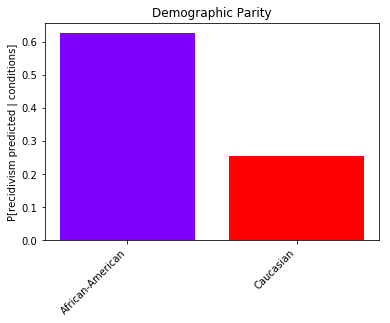

In [6]:
hypotheses = []
with open("hypotheses.pckl", "rb") as f:
    while True:
        try:
            hypotheses.append(pickle.load(f))
        except EOFError:
            break

y_pred = hypotheses[0].predict(X_train)
show_proportions(X_train, sensitive_features_train, y_pred)

In [10]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight='balanced', solver='lbfgs')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)


Demographic Parity
P[recidivism predicted | African-American]                = 0.6097946287519748
P[recidivism predicted | Caucasian]                       = 0.2775147928994083


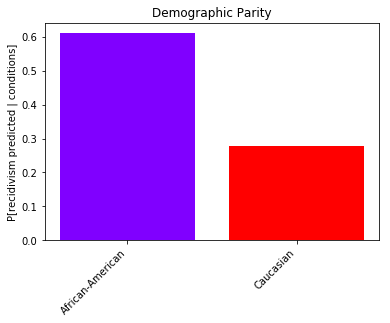

In [11]:
pred = logreg.predict(X_train)
show_proportions(X_train, sensitive_features_train, pred)